In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [3]:
# -*- coding: utf-8 -*-
# from __future__ import absolute_import
# from __future__ import print_function
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from PIL import Image
import csv
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, concatenate
from keras.optimizers import RMSprop, adam
from keras import backend as K
from sklearn.model_selection import train_test_split

epochs = 20
batch_size = 128

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)


def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def hinge_loss(y_true, y_pred):
    margin = K.constant(0.2)
    for i in range(0, batch_size, 2):
        s_pos = K.sum(y_pred[i])
        s_neg = K.sum(y_pred[i + 1])
    return K.maximum(K.constant(0), margin + s_neg - s_pos)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    # print([len(digit_indices[d]) for d in range(num_classes)])
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_image_pairs(rows, ref, pos, neg):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    for i in range(rows):
        ref_patch, pos_patch = ref[i], pos[i]
        pairs += [[ref_patch, pos_patch]]
        ref_patch, neg_patch = ref[i], neg[i]
        pairs += [[ref_patch, neg_patch]]
        labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    '''
    input = Input(shape=input_shape) #return a tensor,shape=(?, 28, 28)
    x = Flatten()(input) #return shape=(?, ?)
    x = Dense(128, activation='elu')(x) #fully connected network
    x = Dropout(0.1)(x)
    x = Dense(128, activation='elu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='elu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='elu')(x)
    '''

    model = Sequential()
    model.add(Conv2D(112, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(112, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(112, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(112, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv2D(112, (3, 3), activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(384, activation='relu'))
    #model.add(Dropout(0.5))
    '''
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(0.1)) 
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(0.1))     
    model.add(Dense(128, activation='elu'))
    model.add(Dropout(0.1))     
    '''

    # model.add(Lambda(lambda x: K.l2_normalize(x, axis=-1)))

    '''
    x.add(Conv2D(64,(3,3)))
    x.add(MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same'))
    x.add(Dropout(0.5))
    x.add(Dense(384))
    x.add(Flatten())
    x.add(Dropout(0.5))
    '''
    print(model.summary())
    return model  # Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)



def accuracy(y_true, y_pred):
    #Compute classification accuracy with a fixed threshold on distances.

    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


img_rows, img_cols = 11, 11

'''
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
'''
# big_file = '/content/drive/My Drive/yan/middlebury0-22.csv'
big_file = '/content/drive/My Drive/cnn/Dataset for Experiments/Modified Dataset 1/417-437.csv'

csv_train = []
csv_test = []
csv_big = []

with open(big_file) as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        csv_big.append(row)
len_threshold = round(len(csv_big) * 0.80)
for i in range(len_threshold):
    csv_train.append(csv_big[i])
for i in range(len_threshold, len(csv_big)):
    csv_test.append(csv_big[i])
csv_big = np.array(csv_big)
csv_train = np.array(csv_train)
csv_test = np.array(csv_test)
[rows_tr, cols] = csv_train.shape
[rows_te, cols] = csv_test.shape
print('csv_big.shape', csv_big.shape)
print('csv_train.shape', csv_train.shape)
print('csv_test.shape', csv_test.shape)

ref_patches_train = csv_train[:, 0:121]
pos_patches_train = csv_train[:, 121:242]
neg_patches_train = csv_train[:, 242:]

ref_patches_new_train = np.zeros(shape=(rows_tr, 11, 11))
pos_patches_new_train = np.zeros(shape=(rows_tr, 11, 11))
neg_patches_new_train = np.zeros(shape=(rows_tr, 11, 11))

for i in range(rows_tr):
    ref_patches_new_train[i] = ref_patches_train[i].reshape((11, 11))
    pos_patches_new_train[i] = pos_patches_train[i].reshape((11, 11))
    neg_patches_new_train[i] = neg_patches_train[i].reshape((11, 11))

print('ref_patch_trains', ref_patches_new_train.shape)
'''
for i in range(10):
    img_ref = Image.fromarray(ref_patches_new_train[i])
    img_pos = Image.fromarray(pos_patches_new_train[i])
    img_neg = Image.fromarray(neg_patches_new_train[i])
    if img_ref.mode != 'RGB':
        img_ref = img_ref.convert('RGB')
    if  img_pos.mode != 'RGB':
        img_pos = img_pos.convert('RGB')
    if img_neg.mode != 'RGB':
        img_neg = img_neg.convert('RGB')
    name_ref = 'ref'+str(i)+'.png'
    name_pos = 'pos'+str(i)+'.png'
    name_neg = 'neg'+str(i)+'.png'
    img_ref.save(name_ref)
    img_pos.save(name_pos)
    img_neg.save(name_neg)
'''
ref_patches_test = csv_test[:, 0:121]
pos_patches_test = csv_test[:, 121:242]
neg_patches_test = csv_test[:, 242:]

ref_patches_new_test = np.zeros(shape=(rows_te, 11, 11))
pos_patches_new_test = np.zeros(shape=(rows_te, 11, 11))
neg_patches_new_test = np.zeros(shape=(rows_te, 11, 11))

print('ref_patch_test', ref_patches_new_test.shape)

for i in range(rows_te):
    ref_patches_new_test[i] = ref_patches_test[i].reshape((11, 11))
    pos_patches_new_test[i] = pos_patches_test[i].reshape((11, 11))
    neg_patches_new_test[i] = neg_patches_test[i].reshape((11, 11))
'''    
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

'''
# remove mean
# data augmentation
input_shape = (img_rows, img_cols, 1)
ref_patches_new_train = ref_patches_new_train.astype('float32')
pos_patches_new_train = pos_patches_new_train.astype('float32')
neg_patches_new_train = neg_patches_new_train.astype('float32')
ref_patches_new_train /= 255
pos_patches_new_train /= 255
neg_patches_new_train /= 255

ref_patches_new_test = ref_patches_new_test.astype('float32')
pos_patches_new_test = pos_patches_new_test.astype('float32')
neg_patches_new_test = neg_patches_new_test.astype('float32')
ref_patches_new_test /= 255
pos_patches_new_test /= 255
neg_patches_new_test /= 255

tr_pairs, tr_y = create_image_pairs(rows_tr, ref_patches_new_train, pos_patches_new_train, neg_patches_new_train)
tr_pairs = np.expand_dims(tr_pairs, axis=-1)
x_train, x_valid, y_train, y_valid = train_test_split(tr_pairs, tr_y, test_size = 0.3, shuffle= False)

print('tr_pairs shape:', tr_pairs[:, 0].shape)
print('tr_y shape:', tr_y.shape)
print(tr_y)

te_pairs, te_y = create_image_pairs(rows_te, ref_patches_new_test, pos_patches_new_test, neg_patches_new_test)
te_pairs = np.expand_dims(te_pairs, axis=-1)
print('te_pairs shape:', te_pairs[:, 1].shape)
print('te_y shape:', te_y.shape)
print(te_y)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])
concatenate_vector = concatenate([processed_a, processed_b], axis=1)
# print('concatenate shape', tf.shape(concatenate_vector))

dense1 = Dense(384, name='dense1', activation='relu')(concatenate_vector)
dense2 = Dense(384, name='dense2', activation='relu')(dense1)
output = Dense(1, name='output_layer', activation='sigmoid')(dense2)

# distance = Lambda(euclidean_distance,
# output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=output)
print(model.summary())

# train
#rms = RMSprop()
rms = RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
# sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='binary_crossentropy', optimizer=rms, metrics=['accuracy'])

print(tr_pairs[:, 0].shape)
hist =    model.fit([x_train[:, 0], x_train[:, 1]], y_train,
          batch_size=128,
          epochs=epochs,
          validation_data=([x_valid[:, 0], x_valid[:, 1]], y_valid))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))




Using TensorFlow backend.


csv_big.shape (228006, 363)
csv_train.shape (182405, 363)
csv_test.shape (45601, 363)
ref_patch_trains (182405, 11, 11)
ref_patch_test (45601, 11, 11)
tr_pairs shape: (364810, 11, 11, 1)
tr_y shape: (364810,)
[1 0 1 ... 0 1 0]
te_pairs shape: (91202, 11, 11, 1)
te_y shape: (91202,)
[1 0 1 ... 0 1 0]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 9, 9, 112)         1120      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 112)         113008    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 112)         0         
_________________________________________________________________
dropout_1 (Dropout)          

In [0]:
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import plot_model, model_to_dot

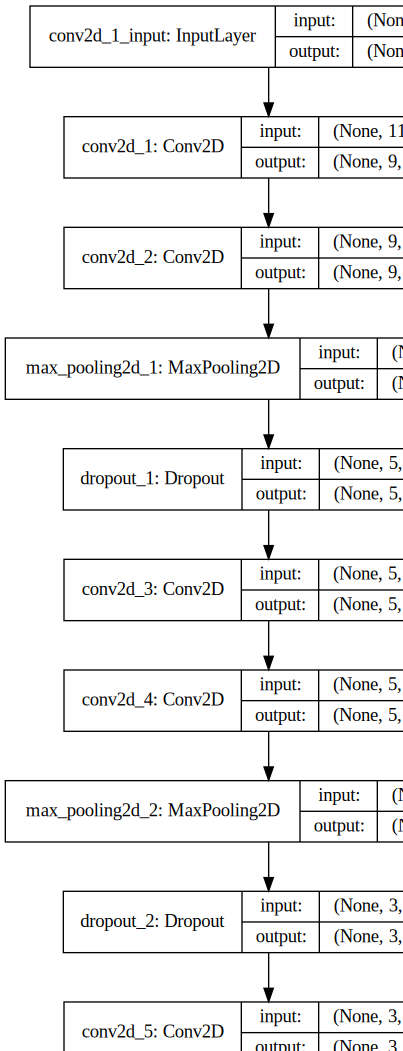

In [0]:
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
SVG(model_to_dot(base_network, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

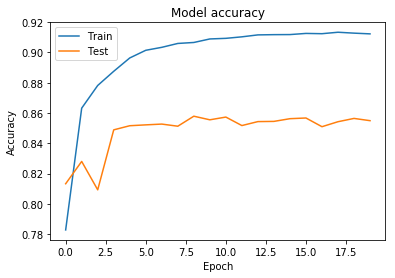

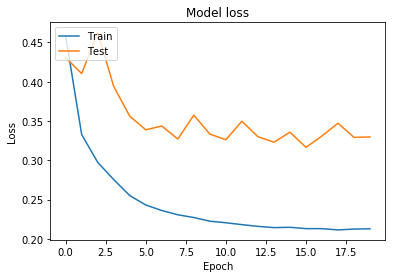

In [0]:
import matplotlib.pyplot as plt



# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()